## Spectral QC on Homer GCI DAS data

originally: Ethan Williams (2023-03-18)

update: Marine Denolle (2024-01-03)



In [1]:
%matplotlib inline
import os
import sys
sys.path.append('../src/')
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.signal import detrend
from obspy.signal.filter import bandpass as bp
from obspy import UTCDateTime
import psf_module as psf


os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

## where is the data

In [2]:
dir0='/Users/marinedenolle/homer'
fdir = dir0+'/kkfln/'

In [3]:
flist = np.array(os.listdir(fdir))
ftime = np.array([psf.get_tstamp(fname) for fname in flist])
index = np.argsort(np.array(ftime)-ftime[0])
flist = flist[index]
ftime = ftime[index]
print(flist)

['decimator2_2024-01-03_21.02.06_UTC.h5'
 'decimator2_2024-01-03_21.03.06_UTC.h5'
 'decimator2_2024-01-03_21.04.06_UTC.h5'
 'decimator2_2024-01-03_21.05.06_UTC.h5'
 'decimator2_2024-01-03_21.06.06_UTC.h5'
 'decimator2_2024-01-03_21.07.06_UTC.h5'
 'decimator2_2024-01-03_21.08.06_UTC.h5'
 'decimator2_2024-01-03_21.09.06_UTC.h5'
 'decimator2_2024-01-03_21.10.06_UTC.h5'
 'decimator2_2024-01-03_21.11.06_UTC.h5'
 'decimator2_2024-01-03_21.12.06_UTC.h5'
 'decimator2_2024-01-03_21.13.06_UTC.h5'
 'decimator2_2024-01-03_21.14.06_UTC.h5'
 'decimator2_2024-01-03_21.15.06_UTC.h5'
 'decimator2_2024-01-03_21.16.06_UTC.h5'
 'decimator2_2024-01-04_00.05.51_UTC.h5'
 'decimator2_2024-01-04_00.06.51_UTC.h5'
 'decimator2_2024-01-04_00.07.51_UTC.h5'
 'decimator2_2024-01-04_00.08.51_UTC.h5'
 'decimator2_2024-01-04_00.09.51_UTC.h5'
 'decimator2_2024-01-04_00.10.51_UTC.h5'
 'decimator2_2024-01-04_00.11.51_UTC.h5'
 'decimator2_2024-01-04_00.12.51_UTC.h5'
 'decimator2_2024-01-04_00.13.51_UTC.h5'
 'decimator2_202

### Check acquisition parameters

In [4]:
fname = flist[0]
with h5py.File(os.path.join(fdir,fname),'r') as fp:
    GL = fp['Acquisition'].attrs['GaugeLength']
    dx = fp['Acquisition'].attrs['SpatialSamplingInterval']
    fs = fp['Acquisition']['Raw[0]'].attrs['OutputDataRate']
    nx = fp['Acquisition']['Raw[0]'].attrs['NumberOfLoci']
    ns = len(fp['Acquisition']['Raw[0]']['RawDataTime'][:])
    #data = fp['Acquisition']['Raw[0]']['RawData'][:]
    print(fname)
    print('Gauge length (m):',GL)
    print('Channel spacing (m):',dx)
    print('Sampling rate (Hz):',fs)
    print('Num channels:',nx)
    print('Num samples:',ns)

decimator2_2024-01-03_21.02.06_UTC.h5
Gauge length (m): 23.928572013009905
Channel spacing (m): 9.571428805203961
Sampling rate (Hz): 25.0
Num channels: 10664
Num samples: 1500


# First plot of the filtered data

### Viz the data

In [5]:
fmin=0.05
fmax=1.

In [6]:
file=fdir+flist[4]
with h5py.File(file, 'r') as fp:
    fs = fp['Acquisition']['Raw[0]'].attrs['OutputDataRate']
    nx = fp['Acquisition']['Raw[0]'].attrs['NumberOfLoci']
    ns = len(fp['Acquisition']['Raw[0]']['RawDataTime'][:])
    data = fp['Acquisition']['Raw[0]']['RawData'][:, :]
    dx = fp['Acquisition'].attrs['SpatialSamplingInterval']

fname = os.path.basename(file)
starttime= ("-").join(fname.split('_')[1:3])

In [7]:
# quick fft of the data 

n2 = int(ns/2)
spec = np.fft.fft(data,axis=0)/n2
freq = np.fft.fftfreq(ns,1./fs)

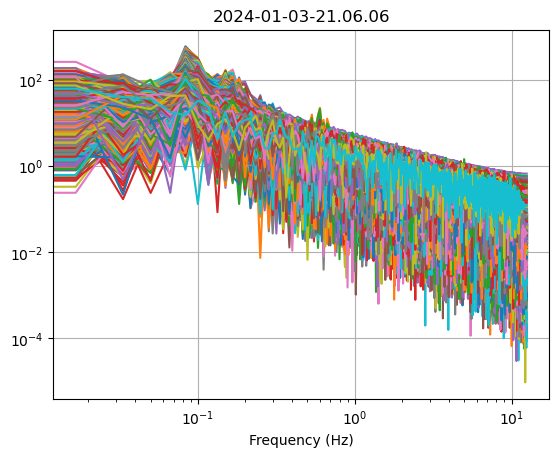

In [8]:
plt.plot(freq[:n2],np.abs(spec[:n2,5000:10000])) 
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.xlabel('Frequency (Hz)');
plt.title(starttime);

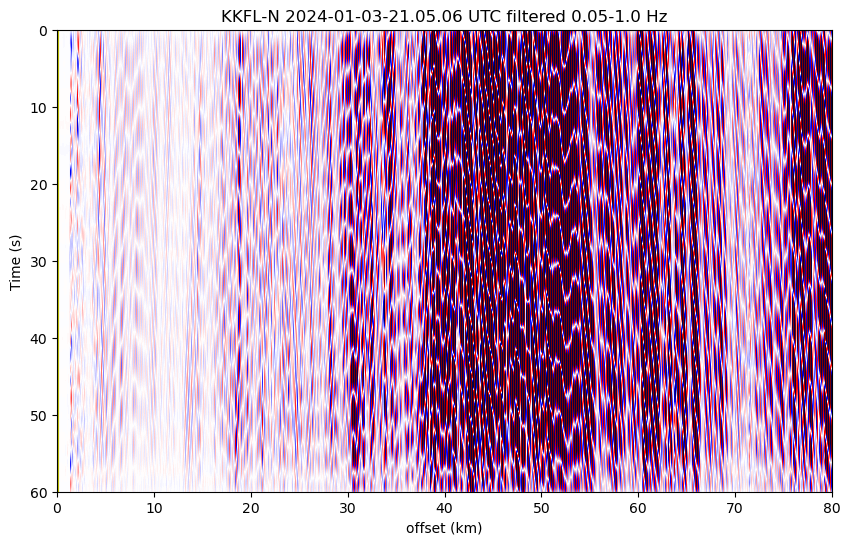

In [9]:
file = fdir+flist[3]
fname = os.path.basename(file)
starttime= ("-").join(fname.split('_')[1:3])
fac=1 # downsampling factor
tv = psf.data_visualizer(file,fac)
tv.filter_data(fmin,fmax)   
tv.plot_data(xlims=[0,80],ylims=[60,0],clims=[-50,50],srcx=0)
plt.title('KKFL-N '+starttime + ' UTC filtered ' +str(fmin)+'-'+str(fmax)+' Hz')
plt.savefig(dir0+'/plots/'+fname[:-3]+'.png')

PSD along the cable

10664 1500


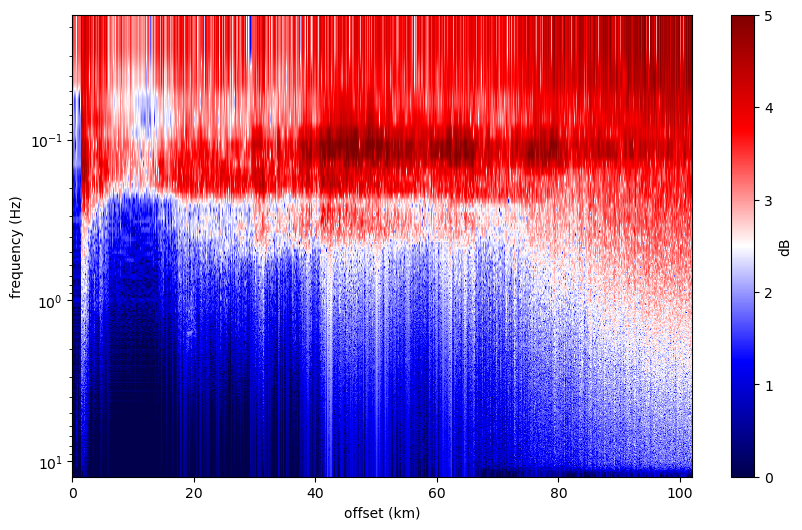

(array([[ 5.44451229,  5.31545928,  5.08218406, ...,  4.83624984,
          4.90218191,  4.1988337 ],
        [ 5.06929525,  4.93091266,  4.71341823, ...,  4.81111204,
          4.68531201,  4.36739577],
        [ 3.46318008,  3.69572528,  3.47621928, ...,  4.04849347,
          4.36912126,  4.15994745],
        ...,
        [-0.17074755, -0.14473342, -0.21409094, ...,  0.75161755,
          1.15226185,  0.39469851],
        [-0.16802205, -0.13969493, -0.21832844, ...,  0.73845708,
          1.14343924,  0.43639534],
        [-0.16901967, -0.14273239, -0.21561137, ...,  0.76039948,
          1.14340486,  0.42345083]]),
 array([ 0.        ,  0.01666667,  0.03333333,  0.05      ,  0.06666667,
         0.08333333,  0.1       ,  0.11666667,  0.13333333,  0.15      ,
         0.16666667,  0.18333333,  0.2       ,  0.21666667,  0.23333333,
         0.25      ,  0.26666667,  0.28333333,  0.3       ,  0.31666667,
         0.33333333,  0.35      ,  0.36666667,  0.38333333,  0.4       ,
        

In [14]:
print(nx,ns)
psf.noise_PSD(fdir,flist[30],nx,ns,clims=[0,5])

## Characterize PSD of ambient field

In [11]:
# Example noise PDF for channel 100
# ns = 1500
chid = 2000 

In [12]:

def noise_PDF(fdir,flist_,ns,chid,fmin,fmax):
    # Load data and calculate spectrum for each file
    data = np.zeros((len(flist_),ns))
    print((len(flist_),ns))
    for ii, fname in enumerate(flist_):
        with h5py.File(os.path.join(fdir,fname),'r') as fp:
            print(detrend(fp['Acquisition']['Raw[0]']['RawData'][:,chid]).shape)
            data[ii,:] = detrend(fp['Acquisition']['Raw[0]']['RawData'][:,chid])
            fs = fp['Acquisition']['Raw[0]'].attrs['OutputDataRate']
    freq = np.tile(np.fft.rfftfreq(ns,d=1./fs),(len(flist_),1)).flatten()
    spec = (20 * np.log10(abs(np.fft.rfft(data,axis=1)))).flatten()
    # Generate noise PDF
    print(spec.shape)
    xbins = np.logspace(np.log10(fmin),np.log10(fmax),100)
    ybins = np.linspace(-20,120,140)
    H,xe,ye = np.histogram2d(freq,spec,bins=(xbins,ybins))
    for ix in range(len(xbins)-1):
        H[ix,:] /= sum(H[ix,:]) 
    xm = (xe[1:] + xe[:-1])/2
    ym = (ye[1:] + ye[:-1])/2
    return H,xm,ym

In [13]:

H,xm,ym = noise_PDF(fdir,flist,ns,chid,0.01,10.)
xm,mn,vr = psf.noise_stats(H,xm,ym)

(676, 1500)
(1500,)
(1500,)
(1500,)
(1500,)
(1500,)
(1500,)
(1500,)
(1500,)
(1500,)
(1500,)
(1500,)
(1500,)
(1500,)
(1500,)
(1500,)
(32,)


ValueError: could not broadcast input array from shape (32,) into shape (1500,)

In [ ]:
plt.figure()
plt.pcolormesh(xm,ym,H.T,cmap='hot_r',vmin=0,vmax=0.2)
plt.plot(xm,mn,'b',linewidth=2,label='mean')
plt.gca().set_xscale('log')
# plt.xlim([min(xm),max(xm)])
plt.ylim([-20,100])
plt.colorbar()
plt.xlabel('Frequency (Hz)')
plt.ylabel('dB rel. strain')
plt.title('Noise PDF for channel %d' % chid)
plt.legend(loc='upper right')

NameError: name 'xm' is not defined

<Figure size 640x480 with 0 Axes>

In [ ]:
# Get mean and variance for all channels
nx = 200
chs = np.arange(nx)
x = chs * dx
files = flist

for ix, chid in enumerate(chs):
    print(ix+1,nx)
    xm,mn,vr = psf.noise_stats(*psf.noise_PDF(fdir,files,ns,chid,fmin,fmax))
    if ix == 0:
        mns = np.zeros((nx,len(mn)))
        vrs = np.zeros((nx,len(vr)))
    mns[ix,:] = mn
    vrs[ix,:] = vr

1 200
2 200


/Users/marinedenolle/GitHub/field_das/homer/../src/psf_module.py:72: RuntimeWarning: invalid value encountered in divide
  H[ix,:] /= sum(H[ix,:])


3 200
4 200
5 200
6 200
7 200
8 200
9 200
10 200
11 200
12 200
13 200
14 200
15 200
16 200
17 200
18 200
19 200
20 200
21 200
22 200
23 200
24 200
25 200
26 200
27 200
28 200
29 200
30 200
31 200
32 200
33 200
34 200
35 200
36 200
37 200
38 200
39 200
40 200
41 200
42 200
43 200
44 200
45 200
46 200
47 200
48 200
49 200
50 200
51 200
52 200
53 200
54 200
55 200
56 200
57 200
58 200
59 200
60 200
61 200
62 200
63 200
64 200
65 200
66 200
67 200
68 200
69 200
70 200
71 200
72 200
73 200
74 200
75 200
76 200
77 200
78 200
79 200
80 200
81 200
82 200
83 200
84 200
85 200
86 200
87 200
88 200
89 200
90 200
91 200
92 200
93 200
94 200
95 200
96 200
97 200
98 200
99 200
100 200
101 200
102 200
103 200
104 200
105 200
106 200
107 200
108 200
109 200
110 200
111 200
112 200
113 200
114 200
115 200
116 200
117 200
118 200
119 200
120 200
121 200
122 200
123 200
124 200
125 200
126 200
127 200
128 200
129 200
130 200
131 200
132 200
133 200
134 200
135 200
136 200
137 200
138 200
139 200
140 200


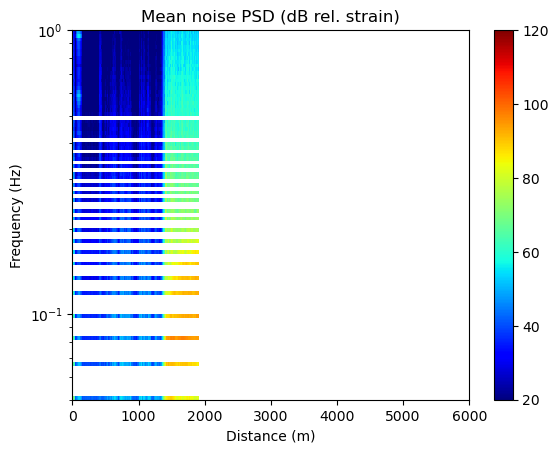

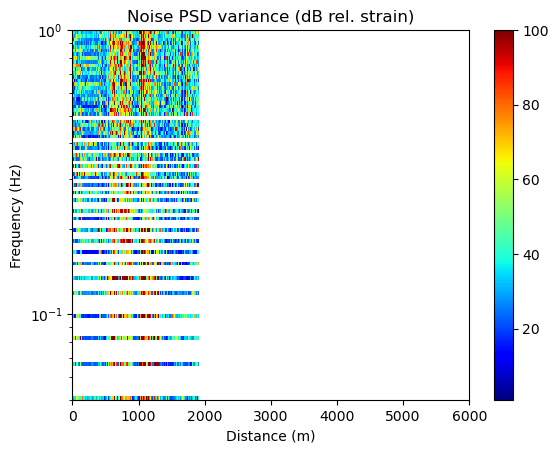

In [ ]:
plt.figure()
plt.pcolormesh(x,xm,mns.T,cmap='jet',vmin=20,vmax=120)
plt.gca().set_yscale('log')
plt.ylim([fmin,fmax])
plt.xlim([0,6000])
plt.xlabel('Distance (m)')
plt.ylabel('Frequency (Hz)')
plt.title('Mean noise PSD (dB rel. strain)')
plt.colorbar()

plt.figure()
plt.pcolormesh(x,xm,vrs.T,cmap='jet',vmin=1,vmax=100)
plt.gca().set_yscale('log')
plt.ylim([fmin,fmax])
plt.xlim([0,6000])
plt.xlabel('Distance (m)')
plt.ylabel('Frequency (Hz)')
plt.title('Noise PSD variance (dB rel. strain)')
plt.colorbar()

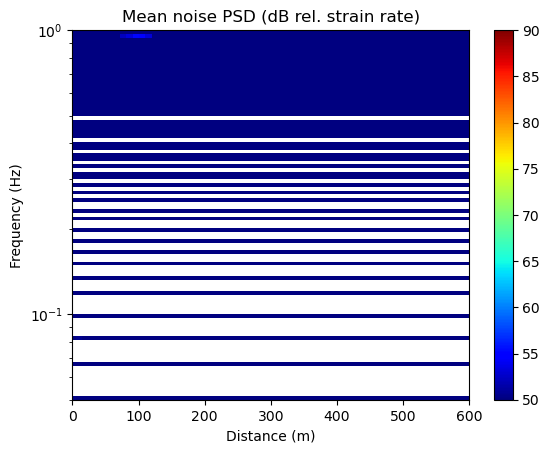

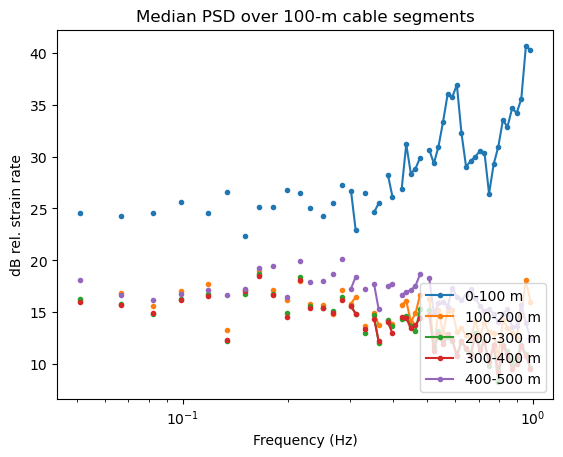

In [ ]:
# Rescale to strain rate for better visualization
f_ = np.tile(xm,(len(x),1))
mn_rate = mns + 20*np.log10(f_)

plt.figure()
plt.pcolormesh(x,xm,mn_rate.T,cmap='jet',vmin=50,vmax=90)
plt.gca().set_yscale('log')
plt.ylim([fmin,fmax])
plt.xlim([0,600])
plt.xlabel('Distance (m)')
plt.ylabel('Frequency (Hz)')
plt.title('Mean noise PSD (dB rel. strain rate)')
plt.colorbar()

plt.figure()
plt.plot(xm,np.median(mn_rate[np.logical_and(x>0,x<100),:],axis=0),label='0-100 m',marker='.')
plt.plot(xm,np.median(mn_rate[np.logical_and(x>100,x<200),:],axis=0),label='100-200 m',marker='.')
plt.plot(xm,np.median(mn_rate[np.logical_and(x>200,x<300),:],axis=0),label='200-300 m',marker='.')
plt.plot(xm,np.median(mn_rate[np.logical_and(x>300,x<400),:],axis=0),label='300-400 m',marker='.')
plt.plot(xm,np.median(mn_rate[np.logical_and(x>400,x<500),:],axis=0),label='400-500 m',marker='.')
plt.gca().set_xscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('dB rel. strain rate')
plt.title('Median PSD over 100-m cable segments')
plt.legend(loc='lower right')